In [3]:
import BioNick as bn
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt

In [4]:
#for vertical distancing of nodes. mean of first and last edge that go right from a node.
def mean_d(m,node,t1):
    sw = False
    for a,b,c in m.values:
        if (sw == False) and (a == node):
            sw = True
            s = t1[b]
        if sw and a != node:
            return (s+pb)/2
        pb = t1[b]
    return (s+pb)/2

#for vertical lines. first and last edge that go right from a node.
def ab(m,node,t1):
    sw = False
    for a,b,c in m.values:
        if (sw == False) and (a == node):
            sw = True
            s = t1[b]
        if sw and a != node:
            return [s,pb]
        pb = t1[b]
    return [s,pb]


#extract leaves
def leaves(nw):
    return [x.split(':')[0].replace('(','') for x in nw.split(',')]

#extract leaves with branch length
def leaves_wb(nw):
    return [x.split(')')[0].replace('(','') for x in nw.split(',')]

#make sure labels are unique. Append numbers if they are not
#assert len(leaves(bt)) == len(set(leaves(bt)))

#label leaves
def lale(nw):
    t = {}
    for i in leaves(nw):
        t[i] = leaves(nw).index(i)
    return t

#convert nw to tsv
def recur_nw_pd(bt,n,t): #,n = len(leaves(bt)),t = []): #default arguments cause trouble
    c = 0
    for i in bt:
        if i == '(':
            c+=1
        if i == ')':
            nt = bt.replace('('+bt.split('(')[c].split(')')[0]+')', '__'+str(n))
            for i2 in bt.split('(')[c].split(')')[0].split(','):
                t.append([n,i2.split(':')[0], float(i2.split(':')[1])])
            n+=1
            c-=1
            return recur_nw_pd(nt,n,t)
    return bt,t


#replace leaves with labels
def encode_leaves(bt,ab):
    #replace leaves with labels
    tb = ab
    ll = lale(bt)
    n = 0
    for a,b,c in tb:
        if b in ll.keys():
            tb[n][1] = ll[b]
        else:
            tb[n][1] = int(b.replace('__',''))
        n+=1
    return tb


#swap root node
def swap_root(tb,x):
    df = pd.DataFrame(tb)
    df2 = df.copy()
    while (x in df[1].unique()):
        #swap
        tmp = int(df.loc[df[1] == x, 0])
        df2.loc[df[1] == x, 0] = int(df2.loc[df[1] == x, 1])
        df2.loc[df[1] == x, 1] = tmp

        #print(tmp,x)
        x = tmp
    return df2


##convert tsv to newick.

#add 10 trailing decimals to the numbers.
def trail(df):
    t = []
    for a,b,c in df.values:
        if isinstance(a,int):
            na = '%016.10f' % a
        else:
            na = a
        if isinstance(b,int):
            nb = '%016.10f' % b
        else:
            nb = b
        t.append((na,nb,c))   
    return pd.DataFrame(t)

#reassign leaf names
def reasign(df2,bt):
    ll = lale(bt)
    inv = {v: k for k, v in ll.items()} #invert keys
    t = []
    for i in df2[1]:
        if i in inv.keys():
            t.append(inv[i])
        else:
            t.append(i)
    df2[1] = t

    df3 = df2.copy()
    
    return df3

def expand_node(df,node):
    tmp = df[df[0] == '%016.10f' % float(node)] #dependency on pandas.
    
    expanded_node = ''
    for a,b,c in tmp.values: #tmp.values when depends on pandas
        expanded_node = expanded_node+','+str(b)+':'+str(c)
    expanded_node = expanded_node[1:]
    return '(' + expanded_node + ')'

def recur_pd_nw(nt,df):
    #lvs = set(list(zip(*tb))[0]) #internal nodes
    int_nodes = df[0].astype(str).unique()
    for i in leaves(nt):
        if i in int_nodes:
            return recur_pd_nw(nt.replace(i,expand_node(df,i)),df)
    return nt    


#flip label order
def expand_node_flip(df,node):
    tmp = df[df[0] == '%016.10f'% float(node)] #dependency on pandas.
    expanded_node = ''
    for a,b,c in tmp.values: #tmp.values when depends on pandas
        expanded_node = str(b)+':'+str(c)+','+expanded_node
    expanded_node = expanded_node[:-1]
    return '(' + expanded_node + ')'
def recur_pd_nw_flip(nt,df):
    int_nodes = df[0].astype(str).unique()
    for i in leaves(nt):
        if i in int_nodes:
            return recur_pd_nw_flip(nt.replace(i,expand_node_flip(df,i)),df)
    return nt    

def flip_all_edges(tree):
    root_node,b = (recur_nw_pd(tree,len(leaves(tree)),[]))
    root_node = int(root_node.replace('__',''))
    tb = encode_leaves(tree,b)
    new = recur_pd_nw_flip('%016.10f' % root_node, trail(reasign(pd.DataFrame(tb),tree))) 
    return new

#flip specified node edges
def recur_pd_nw_flip_at_node(nt,df,node):
    int_nodes = df[0].astype(str).unique()
    for i in leaves(nt):
        if i in int_nodes:
            if i == str('%016.10f' % node):
                return recur_pd_nw_flip_at_node(nt.replace(i,expand_node_flip(df,i)),df,node)
            else:
                return recur_pd_nw_flip_at_node(nt.replace(i,expand_node(df,i)),df,node)  
    return nt   
def flip_leaves_at_node(tree,node):
    root_node,b = (recur_nw_pd(tree,len(leaves(tree)),[]))
    root_node = int(root_node.replace('__',''))
    tb = encode_leaves(tree,b)
    new = recur_pd_nw_flip_at_node('%016.10f' % root_node, trail(reasign(pd.DataFrame(tb),tree)),node)
    return new


#travel through pandas 
## A travelling tree string will still not be identical. The float conversion truncates trailing decimal zeros.
def travel(tree):
    root_node,b = (recur_nw_pd(tree,len(leaves(tree)),[]))
    root_node = int(root_node.replace('__',''))
    tb = encode_leaves(tree,b)
    new = recur_pd_nw('%016.10f' % root_node, trail(reasign(pd.DataFrame(tb),tree)))
    return new


#export trees rooted at every internal node
def all_trees(bt):
    a,b = recur_nw_pd(bt,len(leaves(bt)),[])
    x = set(list(zip(*b))[0])
    
    tb = encode_leaves(bt,b)
    
    t = []
    for i in x:
        t.append(recur_pd_nw('%016.10f' % i, trail(reasign(swap_root(tb,i),bt))))
        print(recur_pd_nw('%016.10f' % i, trail(reasign(swap_root(tb,i),bt))))
    return t

def extract_subtree(tree, leaves_to_keep):
    t = tree
    for leaf in leaves(t):
        if leaf not in leaves_to_keep:
            t = remove_leaf(t,leaf)
    a,b = recur_nw_pd(t,len(leaves(t)),[])
    #prune root
    bd = pd.DataFrame(b)
    mi = bd[bd[0].duplicated(keep = False)][0].max()
    #mi = bd[bd[0] == mn].iloc[-1,0]
    b2 = []
    for l,r,bl in b:
        if l > mi:
            break
        b2.append([l,r,bl])
    bd = pd.DataFrame(b2)
    
    #if nodes don't need joining
    if bd[~bd[0].duplicated(keep = False)].shape[0] == 0:
        c = pd.DataFrame(encode_leaves(t,b2))
        c = trail(reasign(c,t))
        return recur_pd_nw('%016.10f' % mi,c)
    
    #join_singular_nodes
    carry_over = 0
    pl = bd[~bd[0].duplicated(keep = False)].values[0][0]
    pr = bd[~bd[0].duplicated(keep = False)].values[0][1]
    for l,r,bl in bd[~bd[0].duplicated(keep = False)].values[1:]:
        if pl == l-1:
            #print(l,r,bl)
            carry_over = carry_over + bl
        else:
            bd.loc[bd[1] == '__'+str(pl),2] = bd.loc[bd[1] == '__'+str(pl),2] + carry_over
            bd.loc[bd[1] == '__'+str(pl),1] = pr
            pr = r
        pl = l
        #pr = r
    bd.loc[bd[1] == '__'+str(pl),2] = bd.loc[bd[1] == '__'+str(pl),2] + carry_over
    bd.loc[bd[1] == '__'+str(pl),1] = pr
    
    b2 = bd[bd[0].duplicated(keep = False)].round(decimals=8).values
    
    c = pd.DataFrame(encode_leaves(t,b2))
    c = trail(reasign(c,t))
    
    return recur_pd_nw('%016.10f' % mi,c)

#singularize nodes in a tree. i.e., remove extra nodes.
def recur_sin(new):
    for leaf in leaves_wb(new):
        enclosed_leaf = '('+leaf+')'
        if enclosed_leaf in new:
            leaf_without_branch = leaf.split(':')[0]
            inner_branch = float(leaf.split(':')[1])
            outer_branch = float(new.split(enclosed_leaf)[1].split(',')[0].split(')')[0][1:])
            new_branch = round(inner_branch+outer_branch,8)
            enclosed_leaf_with_outer_branch = enclosed_leaf+':'+str(outer_branch)
            new = new.replace(enclosed_leaf_with_outer_branch, leaf_without_branch+':'+str(new_branch))
            return recur_sin(new)
    return new

#remove a leaf from a tree
def remove_leaf(tree,name):
    name = name+':'
    leading = tree.split(name)[0]
    if ',' in tree.split(name)[1]:
        comma = tree.split(name)[1].index(',')
    else:
        comma = 0
    close = tree.split(name)[1].index(')')
    if close < comma:
        trailing = ')'.join(tree.split(name)[1].split(')')[1:])
        new = leading[:-1] + ')' + trailing #:-1 removes last comma
    else:
        trailing = ','.join(tree.split(name)[1].split(',')[1:])
        new = leading + trailing
    
    new = recur_sin(new)
    
    if new[-1] == ',': #if terminal leaf removed
        new = new[:-1]+')'
        
    return new

#order leaves according to a list
def order_leaves(tree,lo):
    lod = pd.DataFrame(list(zip(range(len(lo)),lo)),columns = [3,1])
    root_node,b = recur_nw_pd(tree,len(leaves(tree)),[])
    root_node = int(root_node.replace('__',''))
    b = pd.merge(pd.DataFrame(b),lod,how = 'left').sort_values([0,3],ascending = [1,0]).iloc[:,:3].values
    tb = encode_leaves(tree,b)
    return recur_pd_nw('%016.10f' % root_node, trail(reasign(pd.DataFrame(tb),tree)))    

In [5]:
def draw_clad(tree):
    root_node,b = recur_nw_pd(tree,len(leaves(tree)),[])    
    m = pd.DataFrame(encode_leaves(tree,b))
    
    #vertical node locations
    t1 = dict([(i,i) for i in range(len(leaves(tree)))])
    for a,b,c in m.values:
        if a not in t1.keys():
            t1[a] = mean_d(m,a,t1)
    
    #horizontal node locations. end of edge. point at the right.      
    t2 = {int(root_node.replace('__','')):0}
    for a,b,c in m.values[::-1]:
        if b not in t2.keys():
            t2[b] = t2[a]+c
            
    #horizontal node locations. start of edge. point at the left.  
    t3 = {int(root_node.replace('__','')):0}
    for a,b,c in m.values[::-1]:
        t3[b] = t2[a]
    
    #vertical start and end.
    t4 = {}
    for a,b,c in m.values:
        if a not in t4.keys():
            t4[a] = ab(m,a,t1)
            
    n = pd.concat([pd.DataFrame(t1.values(),index = t1.keys()), 
                   pd.DataFrame(t2.values(),index = t2.keys()), 
                   pd.DataFrame(t3.values(),index = t3.keys())], axis = 1)    

    
    #plt.subplots_adjust(left=3, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    #nodes
    #ax[0,0].scatter(n.iloc[:,1],n.iloc[:,0])
    
    #horizontal lines
    for a,b,c in n.values:
        ax[0].plot([b,c],[a,a], color = 'darkblue')
    
    #vertical lines
    for k,v in t4.items():
        ax[0].plot([t2[k],t2[k]],v, color = 'darkblue')

    #dash to leaves
    for a,b,c in n.values[:len(leaves(tree))]:
        ax[0].plot([c,max(t2.values())],[a,a], linestyle = '--', color = 'darkblue')
    
    ax[0].get_yaxis().set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    #ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)

In [4]:
ma = pd.read_clipboard()

In [6]:
mb = pd.read_clipboard()

In [8]:
ma.to_csv('ma')
mb.to_csv('mb')

In [6]:
ma = pd.read_csv('ma')
mb = pd.read_csv('mb')

In [7]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "monospace"

In [8]:
eut1 = '(Glycine_latifolia:0.28675611,(Styphnolobium_japonicum:0.11512516,(Geum_urbanum:0.92154892,((Spinacia_oleracea:0.2033411,Chenopodium_formosanum:0.26445329):1.21388561,(Coffea_arabica:1.12025617,Actinidia_eriantha:0.59332724):0.13504056):0.96803092):1.56556394):1.68317749)'

In [9]:
ma.index = ma['on']
ma = ma.loc[leaves(eut1)]

In [39]:
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "DejaVu Sans Mono"

In [11]:
import seaborn as sns

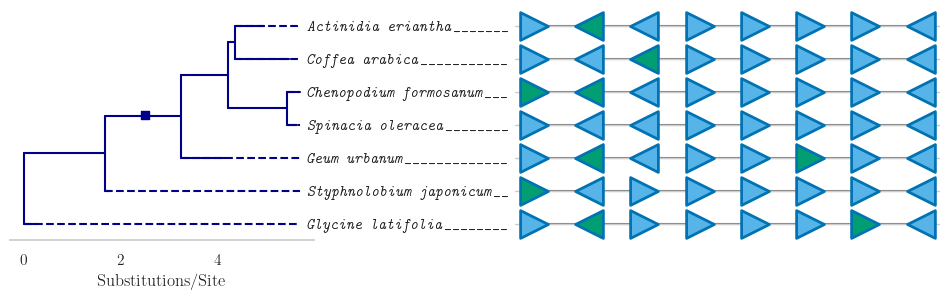

In [40]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1.4]})#, constrained_layout=True)
fig.set_figheight(3)
fig.set_figwidth(12)
plt.subplots_adjust(wspace=0.55, hspace=0.3)

draw_clad(eut1)

cd = {'n' : sns.color_palette("colorblind")[2], 't': sns.color_palette("colorblind")[9]}
od = {'+' : '>', '-' : '<'}

c1=0
for i,r in ma.iterrows():
    ax[1].plot([0,7],[i,i], zorder = 0, linestyle = '-', color = 'grey')
    c2=0
    for i2 in r['tb']:
        ax[1].scatter([c2], [i], color = cd[r['tb'][c2]], marker = od[r['ob'][c2]], s = 400, edgecolor = sns.color_palette("colorblind")[0], linewidths=2)
        c2+=1
    c1+=1


ax[1].set_xticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[1].tick_params(axis=u'both', which=u'both',length=0)

ax[0].set_ylim(-0.5,6.5)
ax[1].set_ylim(-0.5,6.5)

ax[0].scatter([2.5], [3.25+0.03], marker = 's', color = 'darkblue')

ax[0].grid(False)


_ = ax[1].set_yticks(range(7), labels = [r'\texttt{\textit{'+x.split('_')[0]+' '+x.split('_')[1]+'}'+r'_'*(25-len(x))+'}' for x in leaves(eut1)])

ax[0].set_xlabel('Substitutions/Site')

plt.savefig('4Da.pdf', format = 'pdf', bbox_inches="tight")

In [15]:
vet1 = '((Sinocyclocheilus_maitianheensis:0.08802568,Cyprinus_carpio:0.09908469):1.08318213,(Myxocyprinus_asiaticus:0.20874776,(Salmo_salar:0.6105718,(Polyodon_spathula:0.4402759,Gracilinanus_agilis:1.99700652):0.58923533):0.95827873):1.01191473)'

In [16]:
mb.index = mb['genus']
mb = mb.loc[[x.split('_')[0] for x in leaves(vet1)]]

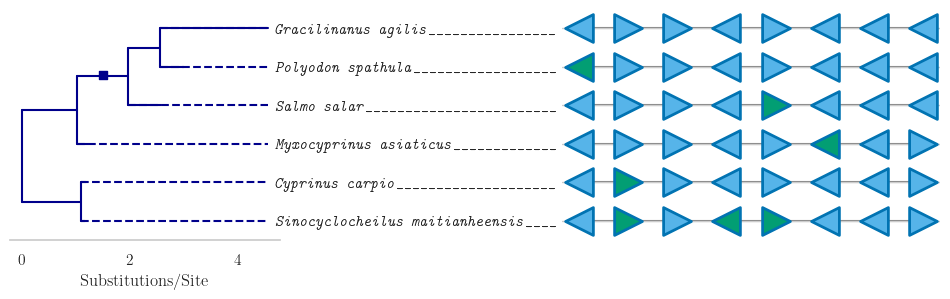

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1.4]})#, constrained_layout=True)
fig.set_figheight(3)
fig.set_figwidth(12)
plt.subplots_adjust(wspace=0.87, hspace=0.3)

draw_clad(vet1)

cd = {'n' : sns.color_palette("colorblind")[2], 't': sns.color_palette("colorblind")[9]}
od = {'+' : '>', '-' : '<'}

c1=0
for i,r in mb.iterrows():
    ax[1].plot([0,7],[i,i], zorder = 0, linestyle = '-', color = 'grey')
    c2=0
    for i2 in r['tb']:
        ax[1].scatter([c2], [i], color = cd[r['tb'][c2]], marker = od[r['ob'][c2]], s = 400, edgecolor = sns.color_palette("colorblind")[0], linewidths=2)
        c2+=1
    c1+=1


ax[1].set_xticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[1].tick_params(axis=u'both', which=u'both',length=0)

ax[0].set_ylim(-0.5,5.5)
ax[1].set_ylim(-0.5,5.5)

ax[0].scatter([1.5], [3.75+0.03], marker = 's', color = 'darkblue')

ax[0].grid(False)

_ = ax[1].set_yticks(range(6), labels = [r'\texttt{\textit{'+x.split('_')[0]+' '+x.split('_')[1]+'}'+r'_'*(35-len(x))+'}' for x in leaves(vet1)])

ax[0].set_xlabel('Substitutions/Site')

plt.savefig('4Db.pdf', format = 'pdf', bbox_inches="tight")

In [161]:
mb

,on,genus,tb,ob,gb,Assembly,cb
genus,,,,,,,
Sinocyclocheilus,Sinocyclocheilus_anshuiensis,Sinocyclocheilus,tntnnttt,-++-+--+,208314at7742_300584at7742_34300at7742_56852at7...,GCA_001515605.1,_y_yy___
Cyprinus,Cyprinus_carpio,Cyprinus,tntttttt,-++-+--+,208314at7742_300584at7742_34300at7742_56852at7...,GCA_027406505.1,_y______
Myxocyprinus,Myxocyprinus_asiaticus,Myxocyprinus,tttttntt,-++-+--+,208314at7742_300584at7742_34300at7742_56852at7...,GCA_019703515.2,_____y__
Salmo,Salmo_salar,Salmo,ttttnttt,-++-+---,208314at7742_300584at7742_34300at7742_56852at7...,GCA_931346935.2,____y___
Polyodon,Polyodon_spathula,Polyodon,nttttttt,-++-+---,208314at7742_300584at7742_34300at7742_56852at7...,GCA_017654505.1,y_______
Gracilinanus,Gracilinanus_agilis,Gracilinanus,tttttttt,-++-+---,208314at7742_300584at7742_34300at7742_56852at7...,GCA_016433145.1,________


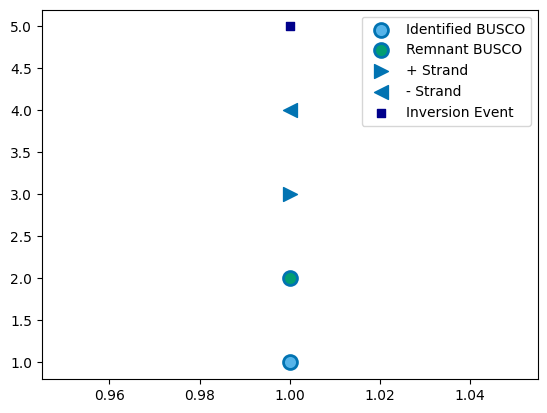

In [20]:
plt.scatter([1],[1],s = 100, color = sns.color_palette("colorblind")[9], edgecolor = sns.color_palette("colorblind")[0], linewidths=2)
plt.scatter([1],[2],s = 100, color = sns.color_palette("colorblind")[2], edgecolor = sns.color_palette("colorblind")[0], linewidths=2)
plt.scatter([1],[3],s = 100, marker = '>', color = sns.color_palette("colorblind")[0])#, edgecolor = sns.color_palette("colorblind")[0], linewidths=2)
plt.scatter([1],[4],s = 100, marker = '<', color = sns.color_palette("colorblind")[0])#, edgecolor = sns.color_palette("colorblind")[0], linewidths=2)

plt.scatter([1], [5], marker = 's', color = 'darkblue')

plt.legend(['Identified BUSCO', 'Remnant BUSCO', '+ Strand', '- Strand', 'Inversion Event'], loc = 'upper right')

plt.grid(False)

plt.savefig('4Dleg.pdf', format = 'pdf')

In [21]:
tf = pd.read_clipboard()

In [22]:
th = pd.read_clipboard()

In [23]:
tj = pd.read_clipboard()

In [24]:
tk = pd.concat([tf['6'],th['6'],tj['6']], axis = 1)
tk.columns = ['All BUSCOS', 'Curated BUSCOs (CUSCOs)', 'Unreliable BUSCOs']

In [25]:
tk = tk.reset_index().melt(id_vars='index', var_name='Subject', value_name='Score')

In [26]:
tl = pd.concat([tf['7'],th['7'],tj['7']], axis = 1)
tl.columns = ['All BUSCOS', 'Curated BUSCOs (CUSCOs)', 'Unreliable BUSCOs']
tl = tl.reset_index().melt(id_vars='index', var_name='Subject', value_name='Score')

In [30]:
tm = pd.read_clipboard()

In [36]:
tf.to_csv('tf')
th.to_csv('th')
tj.to_csv('tj')

In [37]:
tm.to_csv('tm')

In [31]:
tn = tm[['13','15','19']].reset_index().melt(id_vars='index', var_name='Subject', value_name='Score')
to = tm[['14','16','20']].reset_index().melt(id_vars='index', var_name='Subject', value_name='Score')

In [32]:
tp = tm[['13','14','15','16','19','20']].reset_index().melt(id_vars='index', var_name='Subject', value_name='Score')

C:\Users\cat\AppData\Local\Temp\ipykernel_8736\39162173.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax = sns.swarmplot(x="Subject", y="Score", data=tn, color="white", edgecolor="gray")


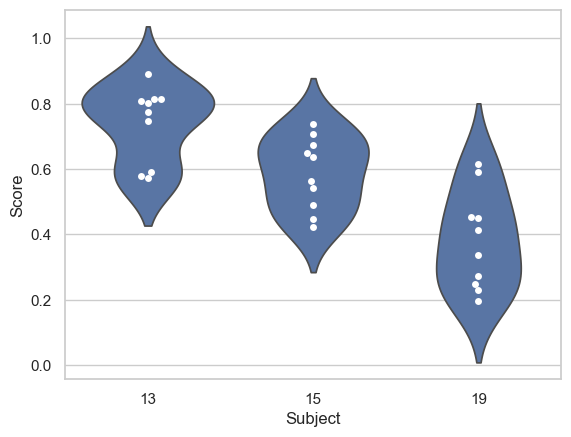

In [33]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

ax = sns.violinplot(x="Subject", y="Score", data=tn, inner=None)
ax = sns.swarmplot(x="Subject", y="Score", data=tn, color="white", edgecolor="gray")

C:\Users\cat\AppData\Local\Temp\ipykernel_40340\3360606147.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax = sns.swarmplot(x="Subject", y="Score", data=to, color="white", edgecolor="gray")


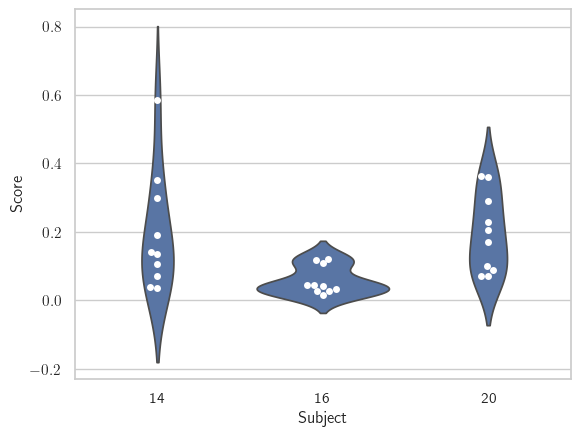

In [244]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

ax = sns.violinplot(x="Subject", y="Score", data=to, inner=None)
ax = sns.swarmplot(x="Subject", y="Score", data=to, color="white", edgecolor="gray")

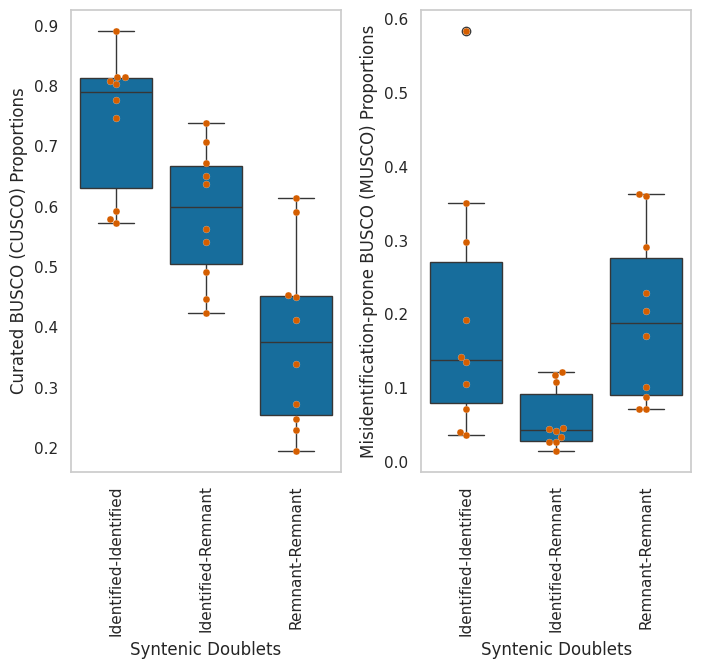

In [42]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1]})#, constrained_layout=True)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.boxplot(x="Subject", y="Score", data=tn, color = sns.color_palette("colorblind")[0], ax = ax[0])
sns.swarmplot(x="Subject", y="Score", data=tn, s = 5, color=sns.color_palette("colorblind")[3], edgecolor="white", linewidth= 0.15, ax = ax[0])

sns.boxplot(x="Subject", y="Score", data=to, color = sns.color_palette("colorblind")[0], ax = ax[1])
sns.swarmplot(x="Subject", y="Score", data=to, s = 5, color=sns.color_palette("colorblind")[3], edgecolor="white", linewidth= 0.15, ax = ax[1])

ax[0].grid(False)
ax[1].grid(False)

ax[0].set_ylabel('Curated BUSCO (CUSCO) Proportions')
ax[0].set_xticks(ax[0].get_xticks(), labels = ['Identified-Identified','Identified-Remnant','Remnant-Remnant'], rotation = 90)
ax[0].set_xlabel('Syntenic Doublets')

ax[1].set_ylabel('Misidentification-prone BUSCO (MUSCO) Proportions')
ax[1].set_xticks(ax[1].get_xticks(), labels = ['Identified-Identified','Identified-Remnant','Remnant-Remnant'], rotation = 90)
ax[1].set_xlabel('Syntenic Doublets')


plt.savefig('4E.pdf', format = 'pdf', bbox_inches="tight")

C:\Users\cat\AppData\Local\Temp\ipykernel_40340\218234274.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  ax = sns.swarmplot(x="Subject", y="Score", data=tp, color="white", edgecolor="gray")


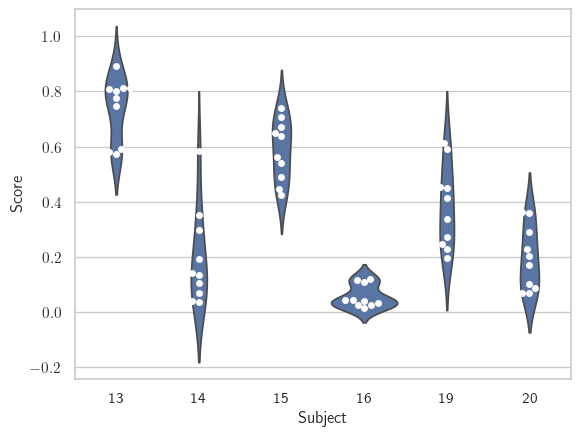

In [246]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

ax = sns.violinplot(x="Subject", y="Score", data=tp, inner=None)
ax = sns.swarmplot(x="Subject", y="Score", data=tp, color="white", edgecolor="gray")

In [215]:
from scipy import stats

In [219]:
stats.ttest_ind(th['6'], tj['6'], equal_var=False)

TtestResult(statistic=4.5820396089975, pvalue=0.00023601555253618693, df=17.844439331162732)

In [223]:
stats.ttest_ind(th['7'], tj['7'], equal_var=False)

TtestResult(statistic=1.0435654407471924, pvalue=0.310971477359036, df=17.39714334681445)

In [224]:
th

,0,1,2,3,4,5,6,7
0,arthropoda,234462,24624,10846,9836,3398,0.440465,0.345466
1,ascomycota,322014,18017,11456,7502,2704,0.635844,0.360437
2,basidiomycota,201817,21349,11220,7974,2310,0.525552,0.289691
3,chlorophyta,66313,5808,1934,2227,270,0.332989,0.121239
4,eudicots,253706,80529,38809,63460,15919,0.481926,0.250851
5,fungi,248836,23590,17211,7336,4418,0.729589,0.602236
6,liliopsida,136110,31136,15312,20081,3675,0.491778,0.183009
7,metazoa,350650,87208,48007,45747,22403,0.550488,0.489715
8,vertebrata,192766,76292,18994,44832,5842,0.248965,0.130309
9,viridiplantae,70087,21416,14379,12399,6844,0.671414,0.551980


In [225]:
tj

,0,1,2,3,4,5,6,7
0,arthropoda,28414,12043,3011,4577,1270,0.250021,0.277474
1,ascomycota,42052,16250,2691,4519,729,0.165600,0.161319
2,basidiomycota,21690,6716,1196,1822,235,0.178082,0.128979
3,chlorophyta,20541,9595,862,3979,287,0.089838,0.072129
4,eudicots,45677,61924,7143,34226,3103,0.115351,0.090662
5,fungi,13930,4384,1593,783,387,0.363367,0.494253
6,liliopsida,46298,47834,5283,28414,1880,0.110444,0.066165
7,metazoa,52378,19839,9334,7428,4315,0.470487,0.580910
8,vertebrata,76842,112840,11302,72180,4551,0.100160,0.063051
9,viridiplantae,7899,5222,1897,1309,662,0.363271,0.505730
